MECE 717 - Pattern Recognition and Machine Learning,
Samat Kabdygali 
Serzhan Omarov
RNN model

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras as keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set the random seed to be sure that results are reproducible
np.random.seed(25)
tf.random.set_seed(25)

# Load the data
data = pd.read_csv("Load_data_new.csv")
data["Time"] = pd.to_datetime(data["Time"])
data.set_index("Time", inplace=True)

# Replace textual descriptions with numerical values
replacement_dict = {
    "no clouds": 0,
    "2/10–3/10.": 3,
    "7/10 – 8/10.": 8,
    "10/10.": 10,
    "4/10.": 4,
    "5/10.": 5,
    "Sky obscured by fog and/or other meteorological phenomena.": 10,
}
data['total_cloud_cover[from ten]'] = data['total_cloud_cover[from ten]'].replace(replacement_dict).astype('float64')

# Create new features for time-related variables
data['hour'] = data.index.hour
data['day_of_year'] = data.index.dayofyear
data['day_of_month'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year


#Create Lag features
num_lags = 3
for i in range(1, num_lags+1):
    data[f'electricity_consumption_lag_{i}'] = data['electricity_demand_values[kw]'].shift(i)
    data[f'heat_consumption_lag_{i}'] = data['heat_demand_values[kw]'].shift(i)

# Rolling window statistics
data['electricity_rolling_mean'] = data['electricity_demand_values[kw]'].rolling(window=3).mean()
data['heat_rolling_mean'] = data['heat_demand_values[kw]'].rolling(window=3).mean()

# Remove NaN values
data = data.dropna()

# Save the preprocessed data
data.to_csv("preprocessed_data1.csv", index=True) 

In [41]:
# Normalize the data
data = data.reset_index()
data = data.drop(columns=["Time"])
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data)

In [43]:
#Split the dataset into training, validation, and testing sets
train_size = int(len(data_norm) * 0.6)
val_size = int(len(data_norm) * 0.2)
test_size = len(data_norm) - train_size - val_size

train, val, test = data_norm[:train_size, :], data_norm[train_size:train_size+val_size, :], data_norm[train_size+val_size:, :]

In [44]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), :-2])
        dataY.append(dataset[i + look_back, -2:])
    return np.array(dataX), np.array(dataY)

In [45]:
# Generate input and output data
look_back = 24
X_train, y_train = create_dataset(train, look_back)
X_val, y_val = create_dataset(val, look_back)
X_test, y_test = create_dataset(test, look_back)

In [46]:
# Define the RNN model architecture(hyperparameters)
model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10))
model.add(Dense(2))

In [47]:
# Compile the RNN model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

callback = keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/50
573/573 - 54s - loss: 0.0113 - val_loss: 0.0069 - lr: 0.0010 - 54s/epoch - 94ms/step
Epoch 2/50
573/573 - 34s - loss: 0.0044 - val_loss: 0.0035 - lr: 0.0010 - 34s/epoch - 60ms/step
Epoch 3/50
573/573 - 33s - loss: 0.0031 - val_loss: 0.0024 - lr: 0.0010 - 33s/epoch - 58ms/step
Epoch 4/50
573/573 - 34s - loss: 0.0023 - val_loss: 0.0017 - lr: 0.0010 - 34s/epoch - 59ms/step
Epoch 5/50
573/573 - 34s - loss: 0.0018 - val_loss: 0.0014 - lr: 0.0010 - 34s/epoch - 59ms/step
Epoch 6/50
573/573 - 35s - loss: 0.0015 - val_loss: 9.8544e-04 - lr: 0.0010 - 35s/epoch - 62ms/step
Epoch 7/50
573/573 - 35s - loss: 0.0013 - val_loss: 0.0010 - lr: 0.0010 - 35s/epoch - 62ms/step
Epoch 8/50
573/573 - 34s - loss: 0.0011 - val_loss: 6.6732e-04 - lr: 0.0010 - 34s/epoch - 60ms/step
Epoch 9/50
573/573 - 34s - loss: 0.0010 - val_loss: 5.1565e-04 - lr: 0.0010 - 34s/epoch - 59ms/step
Epoch 10/50
573/573 - 34s - loss: 9.2150e-04 - val_loss: 4.4096e-04 - lr: 0.0010 - 34s/epoch - 59ms/step
Epoch 11/50
573/573

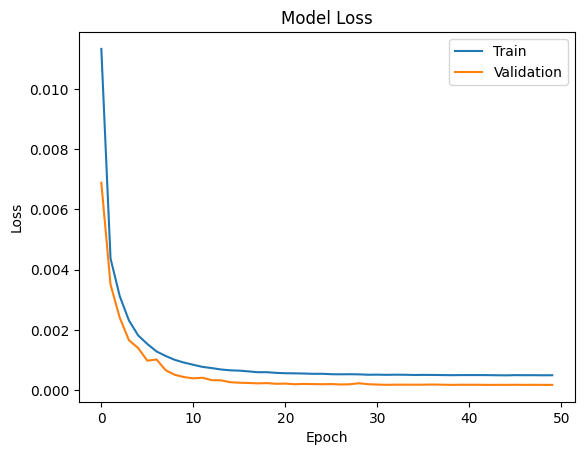

In [48]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_val, y_val), callbacks=[callback], verbose=2)
# Plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [49]:
# Evaluate and make predictions
y_pred = model.predict(X_test)
# Calculate RMSE
rmse_electricity = np.sqrt(mean_squared_error(y_test[:, 0], y_pred[:, 0]))
rmse_heat = np.sqrt(mean_squared_error(y_test[:, 1], y_pred[:, 1]))
print(f"RMSE for electricity demand: {rmse_electricity}")
print(f"RMSE for heat demand: {rmse_heat}")

430/430 [==============================] - 8s 12ms/step
RMSE for electricity demand: 0.01692014354846847
RMSE for heat demand: 0.013406116621930565


In [50]:
mae_electricity = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_heat = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_electricity = r2_score(y_test[:, 0], y_pred[:, 0])
r2_heat = r2_score(y_test[:, 1], y_pred[:, 1])

print(f"R-squared for electricity demand: {r2_electricity}")
print(f"R-squared for heat demand: {r2_heat}")
print(f"MAE for electricity demand: {mae_electricity}")
print(f"MAE for heat demand: {mae_heat}")

R-squared for electricity demand: 0.9902631508269495
R-squared for heat demand: 0.9957475247865681
MAE for electricity demand: 0.012193884680366413
MAE for heat demand: 0.009252529179254683


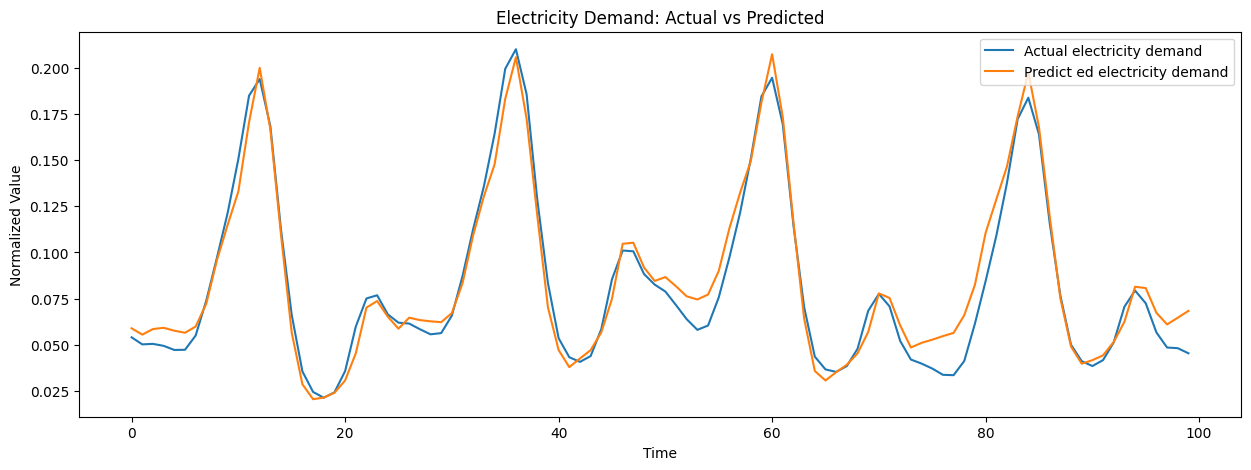

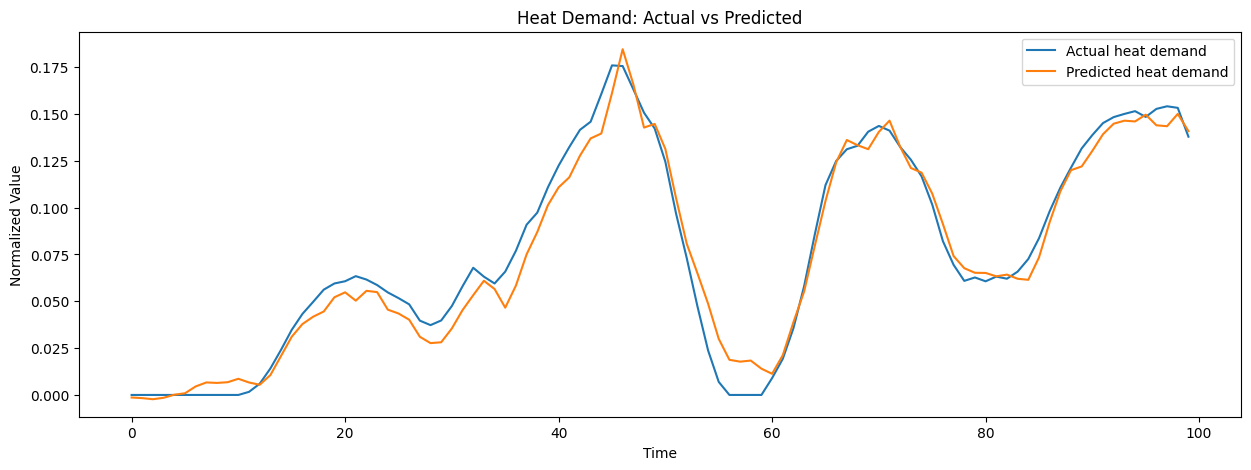

In [51]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test[:100, 0], label="Actual electricity demand")
plt.plot(y_pred[:100, 0], label="Predict ed electricity demand")
plt.title("Electricity Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:100, 1], label="Actual heat demand")
plt.plot(y_pred[:100, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

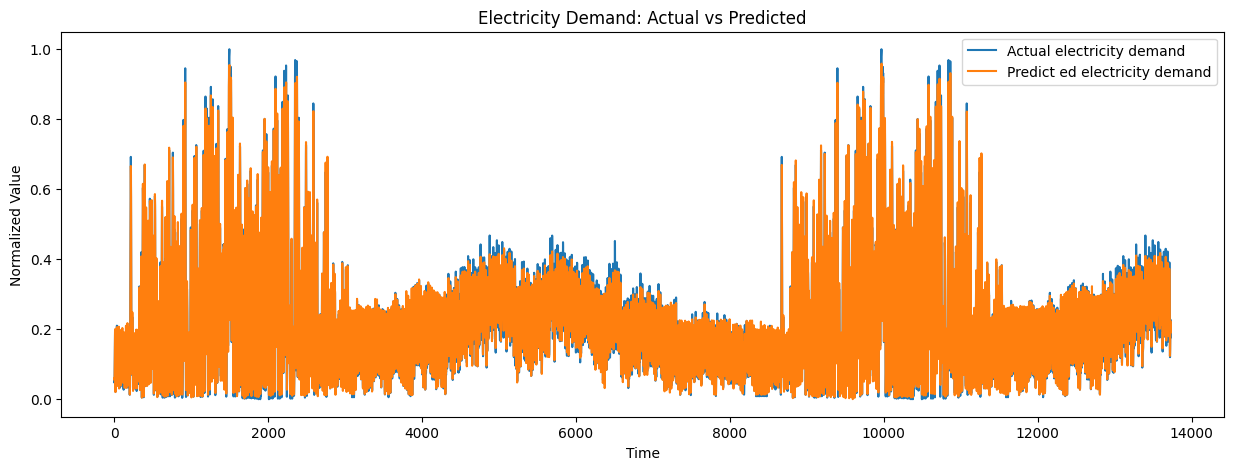

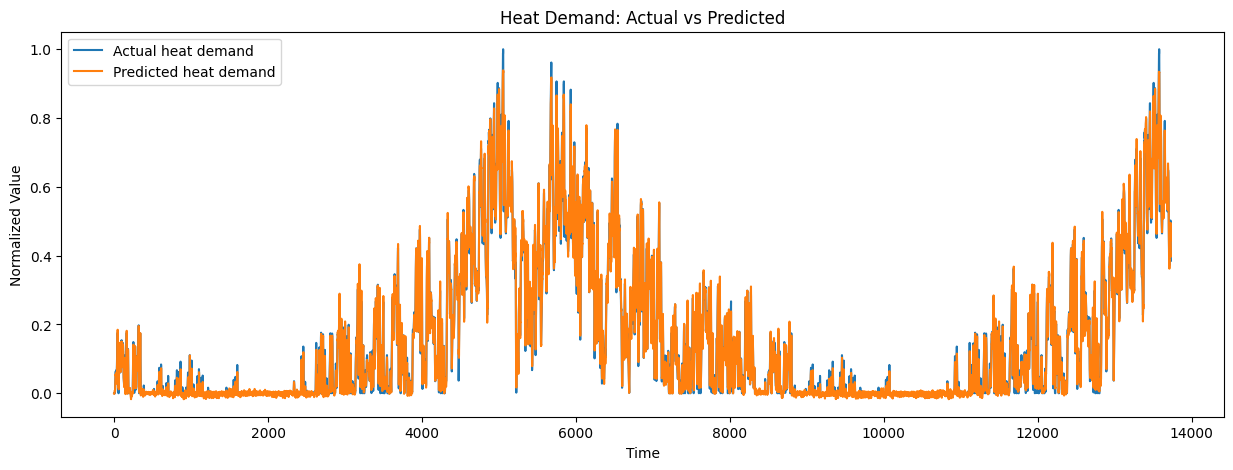

In [52]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test[:14000, 0], label="Actual electricity demand")
plt.plot(y_pred[:14000, 0], label="Predict ed electricity demand")
plt.title("Electricity Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:14000, 1], label="Actual heat demand")
plt.plot(y_pred[:14000, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

In [53]:
# Print some actual and predicted values for comparison
i_range = range(13731)  

for i in i_range:
    print(f"Index {i}: Actual [electricity, heat] = [{y_test[i, 0]:.2f}, {y_test[i, 1]:.2f}], Predicted [electricity, heat] = [{y_pred[i, 0]:.2f}, {y_pred[i, 1]:.2f}]")
    

Index 0: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.06, -0.00]
Index 1: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.06, -0.00]
Index 2: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.06, -0.00]
Index 3: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.06, -0.00]
Index 4: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.06, 0.00]
Index 5: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.06, 0.00]
Index 6: Actual [electricity, heat] = [0.05, 0.00], Predicted [electricity, heat] = [0.06, 0.00]
Index 7: Actual [electricity, heat] = [0.07, 0.00], Predicted [electricity, heat] = [0.07, 0.01]
Index 8: Actual [electricity, heat] = [0.10, 0.00], Predicted [electricity, heat] = [0.10, 0.01]
Index 9: Actual [electricity, heat] = [0.12, 0.00], Predicted [electricity, heat] = [0.12, 0.01]
Index 10: Actual [electric

In [54]:
# Crete denormalized actual and predicted values, respectively.
electricity_demand_idx = data.columns.get_loc("electricity_demand_values[kw]")
heat_demand_idx = data.columns.get_loc("heat_demand_values[kw]")


target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(data.iloc[:, [electricity_demand_idx, heat_demand_idx]])

y_test_denorm = target_scaler.inverse_transform(y_test)
y_pred_denorm = target_scaler.inverse_transform(y_pred)



Index 0: Actual [electricity, heat] = [192.82, 0.00], Predicted [electricity, heat] = [200.07, -2.08]
Index 1: Actual [electricity, heat] = [187.17, 0.00], Predicted [electricity, heat] = [195.01, -2.59]
Index 2: Actual [electricity, heat] = [187.59, 0.00], Predicted [electricity, heat] = [199.47, -3.49]
Index 3: Actual [electricity, heat] = [185.99, 0.00], Predicted [electricity, heat] = [200.47, -2.30]
Index 4: Actual [electricity, heat] = [182.71, 0.00], Predicted [electricity, heat] = [198.15, 0.19]
Index 5: Actual [electricity, heat] = [182.83, 0.00], Predicted [electricity, heat] = [196.50, 1.36]
Index 6: Actual [electricity, heat] = [194.29, 0.00], Predicted [electricity, heat] = [201.46, 6.94]
Index 7: Actual [electricity, heat] = [222.48, 0.00], Predicted [electricity, heat] = [219.98, 10.21]
Index 8: Actual [electricity, heat] = [256.94, 0.00], Predicted [electricity, heat] = [255.01, 9.82]
Index 9: Actual [electricity, heat] = [292.73, 0.00], Predicted [electricity, heat] = 

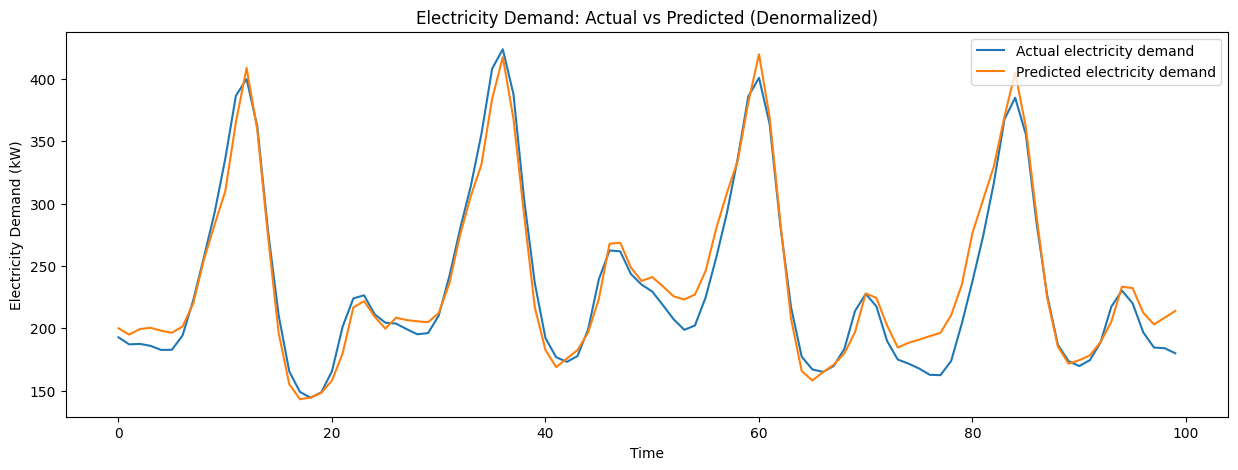

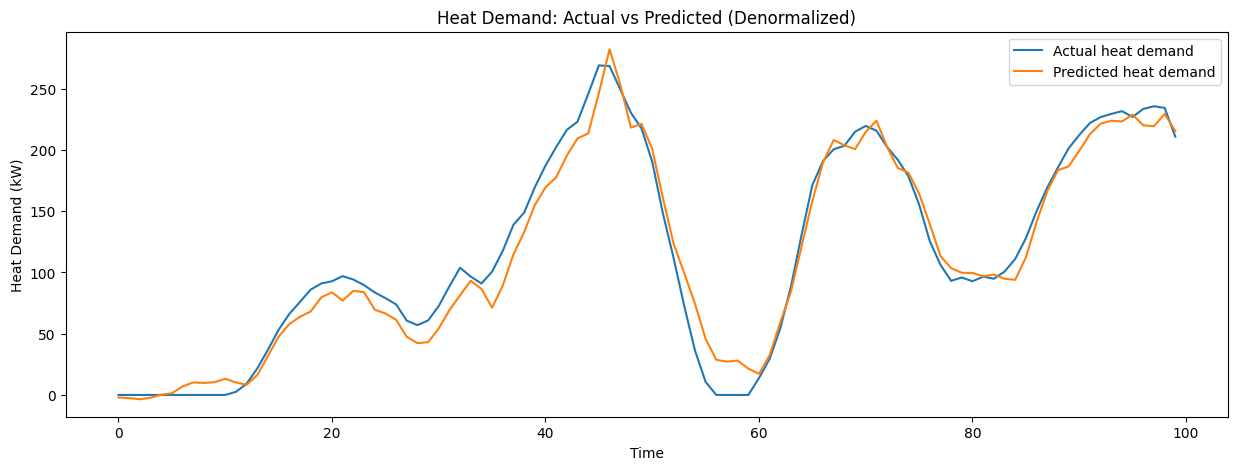

In [55]:
# Print some denormalized actual and predicted values for comparison
i_range = range(13731)

for i in i_range:
    print(f"Index {i}: Actual [electricity, heat] = [{y_test_denorm[i, 0]:.2f}, {y_test_denorm[i, 1]:.2f}], Predicted [electricity, heat] = [{y_pred_denorm[i, 0]:.2f}, {y_pred_denorm[i, 1]:.2f}]")

# Plot actual vs predicted values for denormalized data
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:100, 0], label="Actual electricity demand")
plt.plot(y_pred_denorm[:100, 0], label="Predicted electricity demand")
plt.title("Electricity Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Electricity Demand (kW)")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:100, 1], label="Actual heat demand")
plt.plot(y_pred_denorm[:100, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Heat Demand (kW)")
plt.legend()
plt.show()


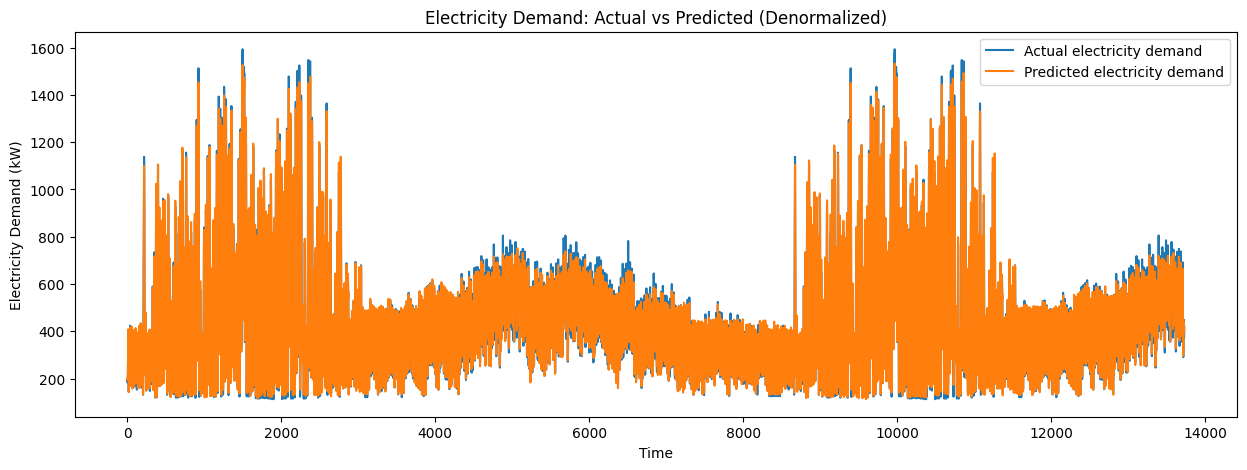

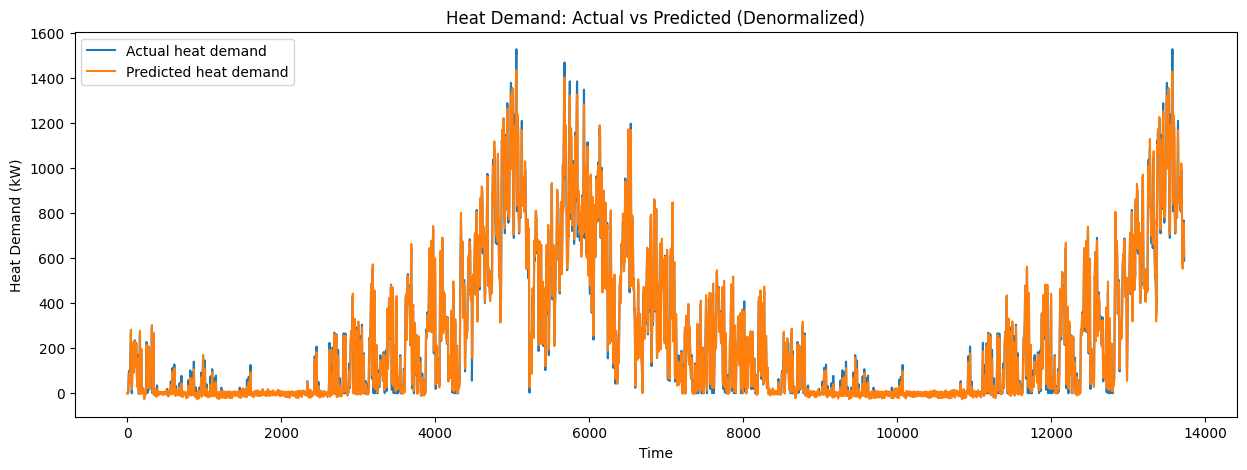

In [56]:
# Plot actual vs predicted values for denormalized data
plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:14000, 0], label="Actual electricity demand")
plt.plot(y_pred_denorm[:14000, 0], label="Predicted electricity demand")
plt.title("Electricity Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Electricity Demand (kW)")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test_denorm[:14000, 1], label="Actual heat demand")
plt.plot(y_pred_denorm[:14000, 1], label="Predicted heat demand")
plt.title("Heat Demand: Actual vs Predicted (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Heat Demand (kW)")
plt.legend()
plt.show()

In [57]:
import pandas as pd

# Create a DataFrame to save it in exel
results = pd.DataFrame({"Index": range(len(y_test_denorm)),
                        "Actual_electricity": y_test_denorm[:, 0],
                        "Actual_heat": y_test_denorm[:, 1],
                        "Predicted_electricity": y_pred_denorm[:, 0],
                        "Predicted_heat": y_pred_denorm[:, 1]})


results.to_excel("actual_vs_predicted.xlsx", index=False)


1/1 [==============================] - 0s 63ms/step


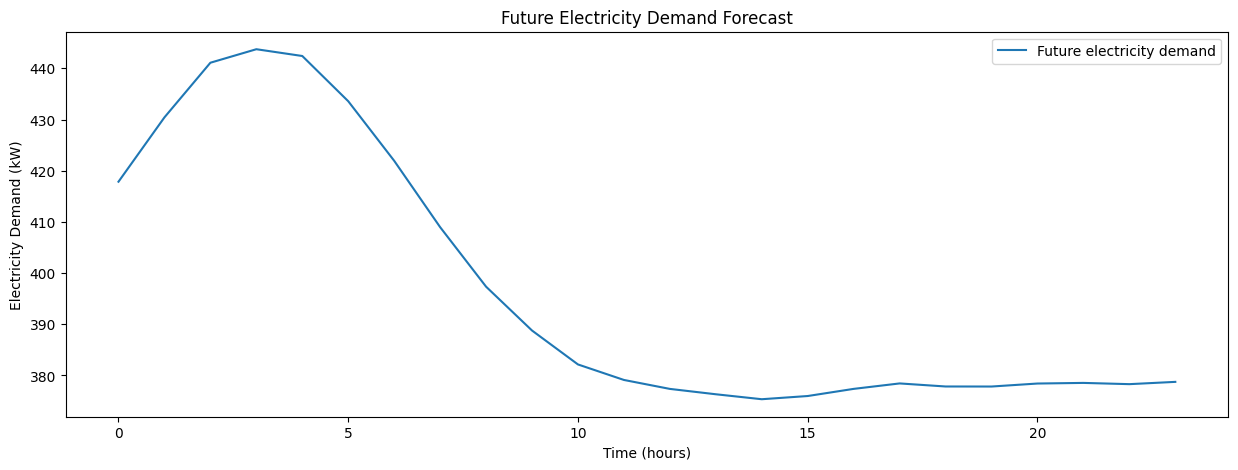

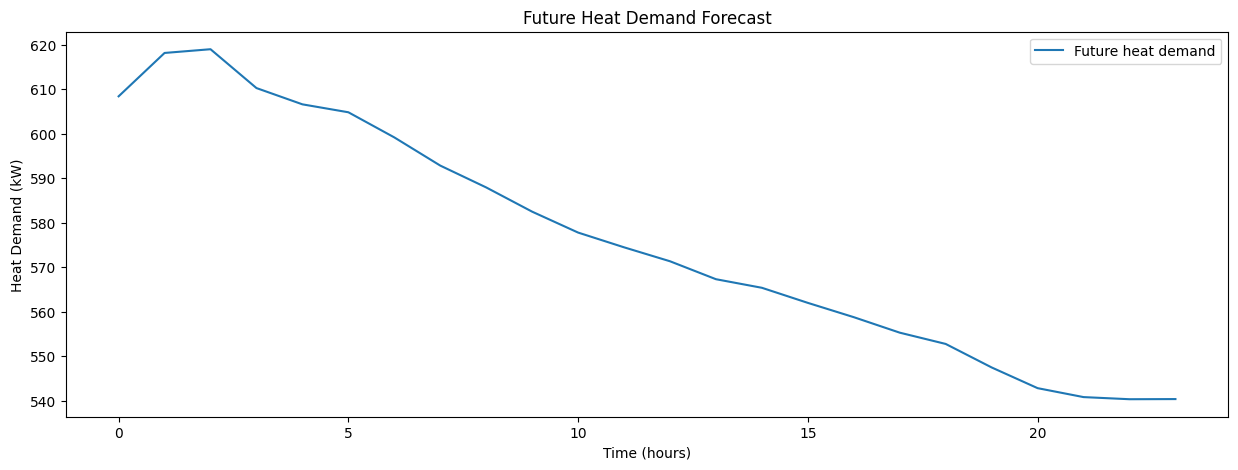

In [60]:
def forecast_future(model, input_seq, n_future_steps):
    future_predictions = []
    input_seq = input_seq.copy()
    
    for _ in range(n_future_steps):
        next_step_prediction = model.predict(input_seq[np.newaxis, :, :])
        future_predictions.append(next_step_prediction[0])
        
        # Remove the first row (oldest timestep) from the input_seq
        input_seq = input_seq[1:, :]
        
        # Add the new predicted values (excluding the target variables) to the input_seq
        input_seq = np.vstack((input_seq, np.hstack((next_step_prediction.reshape(1, -1), input_seq[-1, 2:].reshape(1, -1)))))
    
    return np.array(future_predictions)

# Choose the number of future time steps to forecast
n_future_steps = 24   # For example next 24 hours

# Get the last look_back samples from the test set
last_input_sequence = X_test[-1, :, :]

# Forecast future energy demand
future_predictions_norm = forecast_future(model, last_input_sequence, n_future_steps)

# Denormalize the future predictions
future_predictions_denorm = target_scaler.inverse_transform(future_predictions_norm)

# Visualize the future predictions
plt.figure(figsize=(15, 5))
plt.plot(future_predictions_denorm[:, 0], label="Future electricity demand")
plt.title("Future Electricity Demand Forecast")
plt.xlabel("Time (hours)")
plt.ylabel("Electricity Demand (kW)")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(future_predictions_denorm[:, 1], label="Future heat demand")
plt.title("Future Heat Demand Forecast")
plt.xlabel("Time (hours)")
plt.ylabel("Heat Demand (kW)")
plt.legend()
plt.show()
